# Word Segmentation on Buckeye Allosaurus Output

Herman Kamper, 2021

Train a segmental autoencoding recurrent neural network (segmental AE-RNN) and perform word segmentation on encoded Buckeye.

## Preliminaries

In [1]:
from datetime import datetime
from pathlib import Path
from scipy.stats import gamma
from sklearn import cluster
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn

sys.path.append("..")

from seg_aernn import datasets, models, viterbi
from utils import eval_segmentation

## Utility functions

In [2]:
def get_segmented_sentence(ids, boundaries):
    output = ""
    cur_word = []
    for i_symbol, boundary in enumerate(boundaries):
        cur_word.append(id_to_symbol[ids[i_symbol]])
        if boundary:
            output += "_".join(cur_word)
            output += " "
            cur_word = []
    return output.strip()

In [3]:
# Duration penalty functions

# Histogram
histogram = np.array([
    0, 1.66322800e-01, 2.35838129e-01, 2.10609187e-01,
    1.48025482e-01, 9.42918160e-02, 5.84211098e-02, 3.64679480e-02,
    2.18264741e-02, 1.25420784e-02, 7.18500018e-03, 4.27118399e-03,
    1.73743077e-03, 1.19448366e-03, 7.42027726e-04, 2.89571796e-04,
    2.35277084e-04, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001
    ])  # to-do: check this
histogram = histogram/np.sum(histogram)
def neg_log_hist(dur):
    return -np.log(0 if dur >= len(histogram) else histogram[dur])

# Cached Gamma
# shape, loc, scale = (2.3, 0, 1.3)  # VQ-VAE
# shape, loc, scale = (2.6, 0, 1.8)    # CPC-big
shape, loc, scale = (2.3, 0, 1.5)    # Allosaurus
gamma_cache = []
for dur in range(200):
    gamma_cache.append(gamma.pdf(dur, shape, loc, scale))
gamma_cache = np.array(gamma_cache)/np.sum(gamma_cache)
def neg_log_gamma(dur):
    if dur < 200:
        return -np.log(gamma_cache[dur])
    else:
        return -np.log(0)
    
# Chorowski
def neg_chorowski(dur):
    return -(dur - 1)

## Data

In [83]:
# Dataset
dataset = "buckeye"
split = "val"
seg_tag = "emit1.2"
# seg_tag = "eng_emit1.2"

# Paths
seg_dir = (
    Path("../../allosaurus/exp/allosaurus")/dataset/split/seg_tag/"intervals"
    )
word_ref_dir = Path("../../vqwordseg/data")/dataset/"word_intervals"

In [84]:
# Read phone segmentation
phoneseg_interval_dict = {}
print("Reading: {}".format(seg_dir))
phoneseg_interval_dict = eval_segmentation.get_intervals_from_dir(seg_dir)
utterances = phoneseg_interval_dict.keys()

 16%|█▋        | 2723/16582 [00:00<00:00, 27222.89it/s]

Reading: ../../allosaurus/exp/allosaurus/buckeye/val/emit1.2/intervals


100%|██████████| 16582/16582 [00:00<00:00, 26709.42it/s]


In [85]:
# Read word reference
print("Reading: {}".format(word_ref_dir))
word_ref_interval_dict = eval_segmentation.get_intervals_from_dir(word_ref_dir, utterances)

  0%|          | 0/16582 [00:00<?, ?it/s]

Reading: ../../vqwordseg/data/buckeye/word_intervals


100%|██████████| 16582/16582 [00:00<00:00, 31018.32it/s]


In [86]:
word_types = set()
for utt_key in tqdm(word_ref_interval_dict):
    for start, end, label in word_ref_interval_dict[utt_key]:
        word_types.add(label)
print("No. word types:", len(word_types))

100%|██████████| 16582/16582 [00:00<00:00, 988543.25it/s]

No. word types: 4057


In [87]:
# Convert intervals to boundaries
word_ref_boundaries_dict = {}
for utt_key in tqdm(word_ref_interval_dict):
    word_ref_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        word_ref_interval_dict[utt_key]
        )

100%|██████████| 16582/16582 [00:00<00:00, 304505.41it/s]


In [88]:
prepared_text = []
for utt_key in tqdm(utterances):
    prepared_text.append(
        "_".join([i[2] for i in phoneseg_interval_dict[utt_key]])
        )
    
print(prepared_text[0])

100%|██████████| 16582/16582 [00:00<00:00, 695103.28it/s]

ð_ɒ_s̪_tʰ_e_ɛ_ʀ_ɒ_n_s̪_ɾ_e_ə


In [89]:
# Gold segmentation, where boundaries are inserted in best possible positions
n_not_in_tolerance = 0
prepared_text_gold = []
for utt_key in tqdm(utterances):
    seg_intervals = phoneseg_interval_dict[utt_key].copy()
    ref_intervals = word_ref_interval_dict[utt_key].copy()
    seg_boundaries = np.array([i[1] - 1 for i in seg_intervals])
    ref_boundaries = np.array([i[1] - 1 for i in ref_intervals])
    for ref_boundary in ref_boundaries[:-1]:
        i_seg = np.argmin(np.abs(seg_boundaries - ref_boundary))
        seg_intervals.insert(
            i_seg + 1, (seg_intervals[i_seg][1], seg_intervals[i_seg][1], " ")
            )
        seg_boundaries = np.array([i[1] - 1 for i in seg_intervals])
    cur_text_gold = ""
    for start, end, label in seg_intervals:
        if label == " ":
            cur_text_gold = cur_text_gold[:-1]
            cur_text_gold += " "
        else:
            cur_text_gold += label + "_"
    cur_text_gold = cur_text_gold[:-1]
    prepared_text_gold.append(cur_text_gold)

print(prepared_text_gold[0])

100%|██████████| 16582/16582 [00:00<00:00, 33613.51it/s]

ð_ɒ_s̪ tʰ_e_ɛ_ʀ_ɒ_n_s̪ ɾ_e_ə


No. word types: 26710
Mean training word length: 3.4085
Min training word length:  1
Max training word length:  19
Mean: 3.408532176428055
Gamma parameters: 2.344851022353912 0 1.4536241935772756


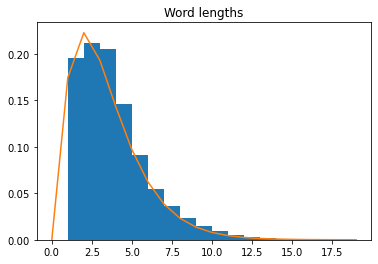

In [90]:
# Training word length statistics
word_lengths = []
n_words = []
word_types = set()
for sentence in prepared_text_gold:
    word_lengths.extend([len(i.split("_")) for i in sentence.split(" ")])
    n_words.append(len(sentence.split(" ")))
    for word in sentence.split(" "):
        word_types.add(word)
#     word_lengths.extend([len(i.replace("$", "")) for i in sentence.split(" ")])  # temp
print("No. word types:", len(word_types))
print("Mean training word length: {:.4f}".format(np.mean(word_lengths)))
print("Min training word length:  {:d}".format(np.min(word_lengths)))
print("Max training word length:  {:d}".format(np.max(word_lengths)))

# Histogram
plt.figure()
n, bins, patches = plt.hist(word_lengths, bins=range(20), density=True)
plt.title("Word lengths")

# Gamma
mean = np.mean(word_lengths)
var  = np.var(word_lengths)
alpha = (mean**2)/var
beta  = alpha / mean
shape = alpha
loc = 0
scale = 1/beta
print("Mean:", mean)
print("Gamma parameters:", shape, loc, scale)
# shape, loc, scale = (2.6, 0, 1.8)
plt.plot(bins, gamma.pdf(bins, shape, loc, scale))

plt.show();

In [91]:
# Vocabulary
PAD_SYMBOL      = "<pad>"
SOS_SYMBOL      = "<s>"    # start of sentence
EOS_SYMBOL      = "</s>"   # end of sentence
BOUNDARY_SYMBOL = " "      # word boundary
symbols = set()
for sentence in prepared_text:
    for char in sentence.split("_"):
        symbols.add(char)
SYMBOLS = [PAD_SYMBOL, SOS_SYMBOL, EOS_SYMBOL, BOUNDARY_SYMBOL] + (sorted(list(symbols)))
symbol_to_id = {s: i for i, s in enumerate(SYMBOLS)}
id_to_symbol = {i: s for i, s in enumerate(SYMBOLS)}

def text_to_id(text, add_sos_eos=False):
    """
    Convert text to a list of symbol IDs.

    Sentence start and end symbols can be added by setting `add_sos_eos`.
    """
    symbol_ids = []
    for word in text.split(" "):
        for code in word.split("_"):
            symbol_ids.append(symbol_to_id[code])
        symbol_ids.append(symbol_to_id[BOUNDARY_SYMBOL])
    symbol_ids = symbol_ids[:-1]  # remove last space

    if add_sos_eos:
        return [symbol_to_id[SOS_SYMBOL]] + symbol_ids + [symbol_to_id[EOS_SYMBOL]]
    else:
        return symbol_ids

print(text_to_id(prepared_text[0]))
print([id_to_symbol[i] for i in text_to_id(prepared_text[0])])

[78, 85, 49, 58, 17, 91, 113, 85, 38, 49, 111, 17, 90]
['ð', 'ɒ', 's̪', 'tʰ', 'e', 'ɛ', 'ʀ', 'ɒ', 'n', 's̪', 'ɾ', 'e', 'ə']


In [92]:
# First three words of training data
word_dataset = datasets.WordDataset(prepared_text, text_to_id)
for i in range(7):
    sample = word_dataset[i]
    print("_".join([id_to_symbol[i] for i in sample.numpy()]))

ð_ɒ_s̪_tʰ_e_ɛ_ʀ_ɒ_n_s̪_ɾ_e_ə
ʔ_ɒ
ɴ_ɨ_ə_w_ɒ_e_n_ɴ_uə_a_ɒ_ɳ_ɴ_o_ɪ_e
None
ɾʲ_ə_t̪_t_ə_ɕ_uː_ə_ʂ_uə_ʁ_uː_z_t_ə_f_a_ɪ_t_ə
ɒ_n_ɳ_n_ɒ_t̪_t͡ɕ_o_uə_z
k_æ_f_t_ə_d_b̥_i_e_ə_b̞_ʌ_ɾ_ə_t_ɹ_ʌ_s_t


In [93]:
# Data

# Approximate ground truth (for debugging)
# cur_train_sentences = prepared_text_gold[:10000]
cur_val_sentences = prepared_text_gold[-1000:]

# No boundaries
cur_train_sentences = prepared_text[:10000]
# cur_val_sentences = prepared_text[-1000:]

# Random boundaries
np.random.seed(42)
# cur_train_sentences = insert_random_boundaries(cur_train_sentences)
# cur_val_sentences = insert_random_boundaries(cur_val_sentences)

print("No. train sentences:", len(cur_train_sentences))
print("Examples:", cur_train_sentences[:3])
print("Min length: ", min([len(i.split("_")) for i in cur_train_sentences]))
print("Max length: ", max([len(i.split("_")) for i in cur_train_sentences]))
print("Mean length: {:.4f}".format(np.mean([len(i.split("_")) for i in cur_train_sentences])))

No. train sentences: 10000
Examples: ['ð_ɒ_s̪_tʰ_e_ɛ_ʀ_ɒ_n_s̪_ɾ_e_ə', 'ʔ_ɒ', 'ɴ_ɨ_ə_w_ɒ_e_n_ɴ_uə_a_ɒ_ɳ_ɴ_o_ɪ_e']
Min length:  1
Max length:  95
Mean length: 11.0467


## Model

In [94]:
# AE-RNN model
n_symbols = len(SYMBOLS)
symbol_embedding_dim = 10  # 25
hidden_dim = 500  # 250  # 500  # 1000  # 200
embedding_dim = 50  # 150  # 300  # 25
teacher_forcing_ratio = 0.5  # 1.0  # 0.5  # 1.0
n_encoder_layers = 1  # 1  # 3  # 10
n_decoder_layers = 1  # 1  # 1
batch_size = 32  # 32*3  # 32
learning_rate = 0.001
input_dropout = 0.0  # 0.0 # 0.5
dropout = 0.0
n_symbols_max = 25
n_epochs_max = 5
bidirectional_encoder = False  # False

encoder = models.Encoder(
    n_symbols=n_symbols,
    symbol_embedding_dim=symbol_embedding_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_encoder_layers,
    dropout=dropout,
    input_dropout=input_dropout,
    bidirectional=bidirectional_encoder
    )
# decoder = models.Decoder1(
#     n_symbols=n_symbols,
#     symbol_embedding_dim=symbol_embedding_dim,
#     hidden_dim=hidden_dim,
#     embedding_dim=embedding_dim,
#     n_layers=n_decoder_layers,
#     sos_id = symbol_to_id[SOS_SYMBOL],
#     teacher_forcing_ratio=teacher_forcing_ratio,
#     dropout=dropout
#     )
decoder = models.Decoder2(
    n_symbols=n_symbols,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_decoder_layers,
    dropout=dropout
    )
model = models.EncoderDecoder(encoder, decoder)

## Pre-training

In [95]:
# Training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Training data
train_dataset = datasets.WordDataset(
    cur_train_sentences, text_to_id, n_symbols_max=n_symbols_max
    )
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Validation data
val_dataset = datasets.WordDataset(cur_val_sentences, text_to_id)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Loss
criterion = nn.NLLLoss(
    reduction="sum", ignore_index=symbol_to_id[PAD_SYMBOL]
    )
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i_epoch in range(n_epochs_max):

    # Training
    model.train()
    train_losses = []
    for i_batch, (data, data_lengths) in enumerate(tqdm(train_loader)):
        optimiser.zero_grad()
        data = data.to(device)       
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        loss = criterion(
            decoder_output.contiguous().view(-1, decoder_output.size(-1)),
            data.contiguous().view(-1)
            )
        loss /= len(data_lengths)
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())
    
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for i_batch, (data, data_lengths) in enumerate(val_loader):
            data = data.to(device)            
            encoder_embedding, decoder_output = model(
                data, data_lengths, data, data_lengths
                )

            loss = criterion(
                decoder_output.contiguous().view(-1,
                decoder_output.size(-1)), data.contiguous().view(-1)
                )
            loss /= len(data_lengths)
            val_losses.append(loss.item())
    
    print(
        "Epoch {}, train loss: {:.3f}, val loss: {:.3f}".format(
        i_epoch,
        np.mean(train_losses),
        np.mean(val_losses))
        )
    sys.stdout.flush()


100%|██████████| 313/313 [00:05<00:00, 57.75it/s]


Epoch 0, train loss: 37.072, val loss: 11.103


100%|██████████| 313/313 [00:05<00:00, 57.92it/s]


Epoch 1, train loss: 33.183, val loss: 8.762


100%|██████████| 313/313 [00:05<00:00, 57.64it/s]


Epoch 2, train loss: 31.224, val loss: 7.474


100%|██████████| 313/313 [00:05<00:00, 59.15it/s]


Epoch 3, train loss: 29.181, val loss: 6.247


100%|██████████| 313/313 [00:05<00:00, 59.16it/s]


Epoch 4, train loss: 27.368, val loss: 5.367


In [96]:
# Examples without segmentation

# Apply to validation data
model.eval()
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(val_loader):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )
        
        y, log_probs = model.decoder.greedy_decode(
            encoder_embedding,
            max_length=25,
            )
        x = data.cpu().numpy()
        
        for i_input in range(y.shape[0]):
            # Only print up to EOS symbol
            input_symbols = []
            for i in x[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                input_symbols.append(id_to_symbol[i])
            output_symbols = []
            for i in y[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                output_symbols.append(id_to_symbol[i])

            print("Input: ", "_".join(input_symbols))
            print("Output:", "_".join(output_symbols))
            print()
            
            if i_input == 10:
                break
        
        break

Input:  ə
Output: ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə_ə

Input:  n_ɑ_tʰ
Output: n_æ_tʰ_tʰ_tʰ_tʰ_tʰ_n_n_n_n_n_n_n_n_n_n_n_n_n_n_n_n_n_n

Input:  uə_p_ɹ_ɾ_ɒ_ɴ_l̪
Output: p_ɾ_ɾ_ɾ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ

Input:  tʂʰ
Output: tʂʰ_ɾ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ɒ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ

Input:  ɪ_ɕ_ә_ɪ_ŋ
Output: ɪ_ɪ_ɕ_ә_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ

Input:  m_ʌ_ɪ_ɾ_tɕʰ_ij
Output: m_ʌ_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m_m

Input:  ɑ_ɹ_ɹ̩_t_ɪ_l_ɹ_ɾ_i
Output: ɹ_ɹ_ɹ_ɹ_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i

Input:  ɴ_ɒ_ŋ
Output: ɴ_ɒ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ

Input:  uə_a_ɪ_k
Output: t̪_a_a_k_k_k_k_k_k_k_k_k_k_ɪ_ɪ_ɪ_ɪ_ɪ_ɪ_ɪ_ɪ_ɪ_ɪ_ɪ_ɪ

Input:  ɨ_ʌ_ŋ
Output: ɨ_ɨ_ɨ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ_ŋ

Input:  f_uə_b̞_ɾʲ_i_ɪ
Output: p_uə_uə_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i_i



## Segmentation

In [97]:
# Utterances for evaluation
n_eval_utterances = 1000 # 10000 # 1000
# eval_sentences = prepared_text[-n_eval_utterances:]  # val sentences
# eval_utterances = list(utterances)[-n_eval_utterances:]
eval_sentences = prepared_text[:n_eval_utterances]
eval_utterances = list(utterances)[:n_eval_utterances]

In [98]:
# Embed segments

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data
sentences = eval_sentences
# sentences = cur_val_sentences
interval_dataset = datasets.SentenceIntervalDataset(
    sentences,
    text_to_id,
    join_char="_"
    )
segment_loader = DataLoader(
    interval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=datasets.pad_collate,
    drop_last=False
    )

# Apply model to data
model.decoder.teacher_forcing_ratio = 1.0
model.eval()
rnn_losses = []
lengths = []
eos = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(segment_loader)):
        data = data.to(device)
        
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        for i_item in range(data.shape[0]):
            item_loss = criterion(
                decoder_output[i_item].contiguous().view(-1,
                decoder_output[i_item].size(-1)),
                data[i_item].contiguous().view(-1)
                )
            rnn_losses.append(item_loss)
            lengths.append(data_lengths[i_item])

100%|██████████| 3155/3155 [00:12<00:00, 254.57it/s]


In [103]:
# Segment

# dur_weight = 2.0  # Chorowski
dur_weight = 1.0

i_item = 0
losses = []
cur_segmented_sentences = []
for i_sentence, intervals in enumerate(tqdm(interval_dataset.intervals)):
    
    # Costs for segment intervals
    costs = np.inf*np.ones(len(intervals))
    i_eos = intervals[-1][-1]
    for i_seg, interval in enumerate(intervals):
        if interval is None:
            continue
        i_start, i_end = interval
        dur = i_end - i_start
        assert dur == lengths[i_item]
        eos = (i_end == i_eos)  # end-of-sequence
        
        # Chorowski
        costs[i_seg] = (
            rnn_losses[i_item]
            + dur_weight*neg_chorowski(dur)
            )
        
        # Gamma
        costs[i_seg] = (
            rnn_losses[i_item]
            + dur_weight*neg_log_gamma(dur)
            + np.log(np.sum(gamma_cache**dur_weight))
            )
        
#         # Poisson
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + neg_log_poisson(dur)
#             )

#         # Histogram
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*(neg_log_hist(dur))
#             + np.log(np.sum(histogram**dur_weight))
#             )
    
        # Sequence boundary
        alpha = 0.9  # 0.3  # 0.9
        if eos:
            costs[i_seg] += -np.log(alpha)
        else:
            costs[i_seg] += -np.log(1 - alpha)

        # Temp
#         if dur > 10 or dur <= 1:
#             costs[i_seg] = +np.inf
        i_item += 1
    
    # Viterbi segmentation
    n_frames = len(interval_dataset.sentences[i_sentence])
    summed_cost, boundaries = viterbi.custom_viterbi(costs, n_frames)
    losses.append(summed_cost)
    
    reference_sentence = sentences[i_sentence]
    segmented_sentence = get_segmented_sentence(
            interval_dataset.sentences[i_sentence],
            boundaries
            )
    cur_segmented_sentences.append(segmented_sentence)
#     # Print examples of the first few sentences
#     if i_sentence < 10:
#         print(reference_sentence)
#         print(segmented_sentence)
#         print()
    
print("NLL: {:.4f}".format(np.sum(losses)))

100%|██████████| 1000/1000 [00:09<00:00, 106.22it/s]

NLL: 23440.4224


## Evaluation

In [104]:
print(cur_segmented_sentences[0])

# # To evaluate gold segmentation:
# cur_segmented_sentences = prepared_text_gold[:n_eval_utterances]
# print(cur_segmented_sentences[0])

ð_ɒ_s̪_tʰ_e ɛ_ʀ ɒ_n_s̪ ɾ_e_ə


In [105]:
# Convert segmentation to intervals
segmentation_interval_dict = {}
for i_utt, utt_key in tqdm(enumerate(eval_utterances)):
    words_segmented = cur_segmented_sentences[i_utt].split(" ")
    word_start = 0
    word_label = ""
    i_word = 0
    segmentation_interval_dict[utt_key] = []
    for (phone_start, phone_end,
            phone_label) in phoneseg_interval_dict[utt_key]:
        word_label += phone_label + "_"
        if words_segmented[i_word] == word_label[:-1]:
            segmentation_interval_dict[utt_key].append((
                word_start, phone_end, word_label[:-1]
                ))
            word_label = ""
            word_start = phone_end
            i_word += 1

    if i_utt < 10:
        print(segmentation_interval_dict[utt_key])
        print(word_ref_interval_dict[utt_key])
        print()        

1000it [00:00, 121026.78it/s]

[(0, 27, 'ð_ɒ_s̪_tʰ_e'), (27, 36, 'ɛ_ʀ'), (36, 54, 'ɒ_n_s̪'), (54, 64, 'ɾ_e_ə')]
[(0, 19, 'those'), (19, 55, 'parents'), (55, 64, 'were')]

[(0, 29, 'ʔ_ɒ')]
[(0, 11, 'i'), (11, 29, 'went')]

[(0, 9, 'ɴ_ɨ'), (9, 21, 'ə_w_ɒ'), (21, 42, 'e_n_ɴ_uə_a'), (42, 99, 'ɒ_ɳ_ɴ_o_ɪ_e')]
[(0, 20, 'no'), (20, 33, 'in'), (33, 57, 'one'), (57, 99, 'week')]

[(0, 49, 'None')]
[(0, 9, 'when'), (9, 15, 'it'), (15, 42, 'happened'), (42, 49, 'in')]

[(0, 12, 'ɾʲ_ə_t̪'), (12, 21, 't_ə'), (21, 36, 'ɕ_uː'), (36, 45, 'ə_ʂ_uə'), (45, 63, 'ʁ_uː_z'), (63, 72, 't_ə'), (72, 90, 'f_a_ɪ'), (90, 103, 't_ə')]
[(0, 10, 'it'), (10, 25, 'was'), (25, 59, 'useless'), (59, 69, 'to'), (69, 95, 'fight'), (95, 103, 'it')]

[(0, 12, 'ɒ_n_ɳ'), (12, 30, 'n_ɒ_t̪'), (30, 71, 't͡ɕ_o_uə_z')]
[(0, 15, 'and'), (15, 31, 'not'), (31, 71, 'just')]

[(0, 24, 'k_æ_f'), (24, 42, 't_ə_d'), (42, 60, 'b̥_i_e_ə'), (60, 72, 'b̞_ʌ_ɾ'), (72, 93, 'ə_t_ɹ'), (93, 123, 'ʌ_s_t')]
[(0, 24, 'tough'), (24, 37, 'to'), (37, 52, 'be'), (52, 67, 'able'), (67, 74,

In [106]:
# Intervals to boundaries
segmentation_boundaries_dict = {}
for utt_key in tqdm(segmentation_interval_dict):
    segmentation_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        segmentation_interval_dict[utt_key]
        )
word_ref_boundaries_dict = {}
for utt_key in tqdm(word_ref_interval_dict):
    word_ref_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        word_ref_interval_dict[utt_key]
        )

# Evaluate word boundaries
reference_list = []
segmentation_list = []
for utterance in segmentation_boundaries_dict:
    reference_list.append(word_ref_boundaries_dict[utterance])
    segmentation_list.append(segmentation_boundaries_dict[utterance])

tolerance = 2
p, r, f = eval_segmentation.score_boundaries(
    reference_list, segmentation_list, tolerance=tolerance
    )
print("-"*(79 - 4))
print("Word boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(eval_segmentation.get_os(p, r)*100))
print("R-value: {:.2f}%".format(eval_segmentation.get_rvalue(p, r)*100))
print("-"*(79 - 4))

p, r, f = eval_segmentation.score_word_token_boundaries(
    reference_list, segmentation_list, tolerance=tolerance
    )
print("Word token boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(eval_segmentation.get_os(p, r)*100))
# print("R-value: {:.2f}%".format(get_rvalue(p, r)*100))
print("-"*(79 - 4))

100%|██████████| 16582/16582 [00:00<00:00, 290059.76it/s]

---------------------------------------------------------------------------
Word boundaries:
Precision: 30.79%
Recall: 33.08%
F-score: 31.89%
OS: 7.44%
R-value: 40.04%
---------------------------------------------------------------------------
Word token boundaries:
Precision: 19.61%
Recall: 20.64%
F-score: 20.11%
OS: 5.30%
---------------------------------------------------------------------------


## Quantization

In [24]:
# clustering_sentences = prepared_text_gold[:10000]
# clustering_sentences = prepared_text[:10000]  # probably doesn't make sense
clustering_sentences = cur_segmented_sentences

In [25]:
# K-means centroids

# Data
train_dataset = datasets.WordDataset(
    clustering_sentences, text_to_id, n_symbols_max=n_symbols_max
    )
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Apply model to data
model.eval()
encoder_embeddings = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )
        encoder_embeddings.append(encoder_embedding.cpu().numpy())
        
# Cluster
X = np.vstack(encoder_embeddings)
print("X shape:", X.shape)
print(datetime.now())
K = 4096 # 1024  # 1024  # 2048
print("Clustering: K = {}".format(K))
vq_model = cluster.KMeans(n_clusters=K, max_iter=10)
vq_model.fit(X)
print("Inertia: {:.4f}".format(vq_model.inertia_))
centroids = vq_model.cluster_centers_
print(datetime.now())

100%|██████████| 117/117 [00:00<00:00, 576.87it/s]

X shape: (3733, 50)
2021-08-03 12:33:50.692940
Clustering: K = 4096


ValueError: n_samples=3733 should be >= n_clusters=4096

In [ ]:
# Examples without segmentation

# Apply to validation data
model.eval()
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(val_loader):
#     for i_batch, (data, data_lengths) in enumerate(train_loader):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        encoder_embedding = encoder_embedding.cpu().numpy()
        clusters = vq_model.predict(encoder_embedding)
        embedding_reconstructed = centroids[clusters, :].reshape(
            encoder_embedding.shape
            )
        embedding_reconstructed = torch.from_numpy(
            embedding_reconstructed
            ).to(device)
        
        y, log_probs = model.decoder.greedy_decode(
            embedding_reconstructed,
            max_length=n_symbols_max,
            )
        x = data.cpu().numpy()
        
        for i_input in range(y.shape[0]):
            # Only print up to EOS symbol
            input_symbols = []
            for i in x[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                input_symbols.append(id_to_symbol[i])
            output_symbols = []
            for i in y[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                output_symbols.append(id_to_symbol[i])

            print("Input: ", "_".join(input_symbols))
            print("Output:", "_".join(output_symbols))
            print()
            
            if i_input == 10:
                break
        
        break

In [ ]:
# Utterances for evaluation
n_eval_utterances = 1000
# eval_sentences = prepared_text[-n_eval_utterances:]  # val sentences
# eval_utterances = list(utterances)[-n_eval_utterances:]
eval_sentences = prepared_text[:n_eval_utterances]
eval_utterances = list(utterances)[:n_eval_utterances]

In [ ]:
# Embed segments

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data
sentences = eval_sentences
interval_dataset = datasets.SentenceIntervalDataset(
    sentences,
    text_to_id,
    "_"
    )
segment_loader = DataLoader(
    interval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=datasets.pad_collate,
    drop_last=False
    )

# Apply model to data
model.decoder.teacher_forcing_ratio = 1.0  # to-do: adjust this
model.eval()
rnn_losses = []
lengths = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(segment_loader)):
        data = data.to(device)

        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        encoder_embedding = encoder_embedding.cpu().numpy()
        clusters = vq_model.predict(encoder_embedding)
        embedding_reconstructed = centroids[clusters, :].reshape(
            encoder_embedding.shape
            )
        embedding_reconstructed = torch.from_numpy(
            embedding_reconstructed
            ).to(device)
        
        decoder_rnn, decoder_output = model.decoder(
            embedding_reconstructed, data, data_lengths
            )

        for i_item in range(data.shape[0]):
            item_loss = criterion(
                decoder_output[i_item].contiguous().view(-1,
                decoder_output[i_item].size(-1)),
                data[i_item].contiguous().view(-1)
                )
            rnn_losses.append(item_loss)
            lengths.append(data_lengths[i_item])

Options:

- Want to evaluate this segmentation: Go back up to the cell where segmentation is done (after segments are embedded).
- Want to retrain K-means model based on this segmentation: Go back to start of quantization cell.